# Prepare synthetic data

We need synthetic data.  
We will inspect live data in this notebook, and then derive a short script that will generate suitable dummy data.

**NOTE**

This notebook will be be run manually.  
That should happen from the _project root directory_ where the `readme.md` and the `.env` file are stored.

The following changes to the project root assuming that the notebook kernel is normally starting from the same directory as the notebook itself.

In [1]:
%cd ../..

/data/hymind/home/steve/HyStakes


In [11]:
import os
from dotenv import load_dotenv
from pathlib import Path

import plotly.express as px
import numpy as np
import pandas as pd
import sqlalchemy as sa

## Load environment variables

Load environment variables and set-up SQLAlchemy connection engine for the EMAP Star

In [3]:
load_dotenv(dotenv_path=".env")
try:
    assert os.getenv("DOTENV_FILE_EXISTS") == 'TRUE'
except AssertionError:
    print("!!! ERROR: check that the .env file exists at the top level of the project")
    print("!!! ERROR: check that the relative path is correct")

In [4]:
# Construct the PostgreSQL connection
uds_host = os.getenv('EMAP_DB_HOST')
uds_name = os.getenv('EMAP_DB_NAME')
uds_port = os.getenv('EMAP_DB_PORT')
uds_user = os.getenv('EMAP_DB_USER')
uds_passwd = os.getenv('EMAP_DB_PASSWORD')

emapdb_engine = sa.create_engine(f'postgresql://{uds_user}:{uds_passwd}@{uds_host}:{uds_port}/{uds_name}')

Here's the _very_ long query that I built.  
It selects all patients on tower wards 2 weeks ago (336 hours), and then finds the age (rounded) and the last heart rate. The remaining data has _no_ identifiers.

```sql

SELECT
 left(md5(lv.hospital_visit_id::TEXT), 6) id
--,lv.location_visit_id
--,lv.admission_datetime admit_dt_bed
--,lv.discharge_datetime disch_dt_bed
--,hv.admission_datetime admit_dt_hosp
--,hv.discharge_datetime disch_dt_hosp
,ROUND(EXTRACT(epoch FROM 
    (hv.discharge_datetime - (NOW() - '336 HOURS'::INTERVAL)
    ))/3600) hours_to_discharge
--,hv.discharge_destination
--,hv.patient_class
--,lo.location_string
,dept.name department

-- include age rounded to 5
, ROUND(DATE_PART('year',AGE(cd.date_of_birth ))/5) * 5 AGE

-- add last heart rate
,hr.value_as_real pulse
--,hr.observation_datetime


FROM star.location_visit lv
LEFT JOIN star.location lo ON lv.location_id = lo.location_id
LEFT JOIN star.department dept ON lo.department_id = dept.department_id 
LEFT JOIN star.hospital_visit hv ON lv.hospital_visit_id = hv.hospital_visit_id
LEFT JOIN star.core_demographic cd ON hv.mrn_id = cd.mrn_id
LEFT JOIN (
    WITH obs AS (
        SELECT

         vo.visit_observation_id
        ,vo.hospital_visit_id
        ,vo.observation_datetime
        ,vo.value_as_real
        ,ot.name

        FROM star.visit_observation vo
        LEFT JOIN star.visit_observation_type ot ON vo.visit_observation_type_id = ot.visit_observation_type_id
        WHERE 
        ot.id_in_application = '8' -- heart rate
        AND
        vo.observation_datetime < NOW() - '336 HOURS'::INTERVAL 
        AND
        vo.observation_datetime > NOW() - '360 HOURS'::INTERVAL 
    ),
    obs_tail AS (
        SELECT 
         obs.*
        ,row_number() over (partition BY obs.hospital_visit_id ORDER BY obs.observation_datetime DESC) obs_tail
        FROM obs
    )
    SELECT 
     visit_observation_id
    ,hospital_visit_id
    ,observation_datetime
    ,value_as_real
    ,NAME
    FROM obs_tail 
    WHERE obs_tail = 1
) hr -- heart rate
ON lv.hospital_visit_id = hr.hospital_visit_id

WHERE 
dept.name IN (
'UCH T03 INTENSIVE CARE'
,'UCH SDEC'
,'UCH T01 ACUTE MEDICAL'
,'UCH T01 ENHANCED CARE'
,'UCH T06 HEAD (T06H)'
,'UCH T06 CENTRAL (T06C)'
,'UCH T06 SOUTH PACU'
,'UCH T06 GYNAE (T06G)'
,'UCH T07 NORTH (T07N)'
,'UCH T07 CV SURGE'
,'UCH T07 SOUTH'
,'UCH T07 SOUTH (T07S)'
,'UCH T07 HDRU'
,'UCH T08 NORTH (T08N)'
,'UCH T08 SOUTH (T08S)'
,'UCH T08S ARCU'
,'UCH T09 SOUTH (T09S)'
,'UCH T09 NORTH (T09N)'
,'UCH T09 CENTRAL (T09C)'
,'UCH T10 SOUTH (T10S)'
,'UCH T10 NORTH (T10N)'
,'UCH T10 MED (T10M)'
,'UCH T11 SOUTH (T11S)'
,'UCH T11 NORTH (T11N)'
,'UCH T11 EAST (T11E)'
,'UCH T11 NORTH (T11NO)'
,'UCH T12 SOUTH (T12S)'
,'UCH T12 NORTH (T12N)'
,'UCH T13 SOUTH (T13S)'
,'UCH T13 NORTH ONCOLOGY'
,'UCH T13 NORTH (T13N)'
,'UCH T14 NORTH TRAUMA'
,'UCH T14 NORTH (T14N)'
,'UCH T14 SOUTH ASU'
,'UCH T14 SOUTH (T14S)'
,'UCH T15 SOUTH DECANT'
,'UCH T15 SOUTH (T15S)'
,'UCH T15 NORTH (T15N)'
,'UCH T15 NORTH DECANT'
,'UCH T16 NORTH (T16N)'
,'UCH T16 SOUTH (T16S)'
,'UCH T16 SOUTH WINTER'

)
AND
lv.admission_datetime < NOW() - '336 HOURS'::INTERVAL 
AND
    (lv.discharge_datetime > NOW() - '336 HOURS'::INTERVAL 
     OR
      (lv.discharge_datetime IS NULL AND hv.discharge_datetime IS NULL)
    )
AND 
lo.location_string NOT LIKE '%WAIT%'
AND 
lo.location_string NOT LIKE '%null%'
;
```

In [16]:
q = Path('utils/queries/discharges_dummy.sql').read_text()

# this handles escaping etc (e.g. % should be %%)
q = sa.text(q)

In [17]:
df = pd.read_sql_query(q, emapdb_engine)

In [ ]:
df.head()

In [19]:
df.department.value_counts()

UCH T10 SOUTH (T10S)      34
UCH T01 ACUTE MEDICAL     33
UCH SDEC                  30
UCH T09 NORTH (T09N)      26
UCH T03 INTENSIVE CARE    25
UCH T10 NORTH (T10N)      23
UCH T13 SOUTH (T13S)      22
UCH T13 NORTH ONCOLOGY    22
UCH T07 NORTH (T07N)      19
UCH T09 CENTRAL (T09C)    19
UCH T08 SOUTH (T08S)      19
UCH T08 NORTH (T08N)      18
UCH T16 NORTH (T16N)      16
UCH T14 NORTH TRAUMA      15
UCH T12 NORTH (T12N)      15
UCH T14 SOUTH ASU         14
UCH T16 SOUTH WINTER      14
UCH T06 HEAD (T06H)       14
UCH T01 ENHANCED CARE     14
UCH T12 SOUTH (T12S)      11
UCH T11 NORTH (T11N)      10
UCH T07 SOUTH             10
UCH T06 SOUTH PACU         9
UCH T06 CENTRAL (T06C)     9
UCH T11 SOUTH (T11S)       9
UCH T14 NORTH (T14N)       4
UCH T06 GYNAE (T06G)       3
UCH T09 SOUTH (T09S)       3
UCH T07 SOUTH (T07S)       2
UCH T15 SOUTH (T15S)       2
UCH T10 MED (T10M)         1
UCH T08S ARCU              1
UCH T15 NORTH (T15N)       1
UCH T16 SOUTH (T16S)       1
Name: departme

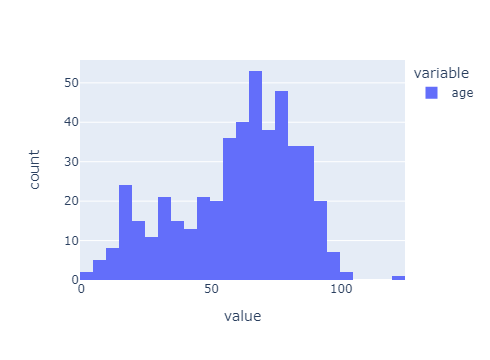

In [20]:
px.histogram(df.age)

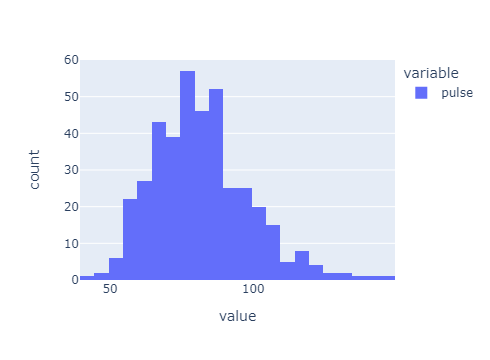

In [21]:
px.histogram(df.pulse)

In [22]:
df.hours_to_discharge

0       16.0
1      324.0
2        NaN
3       17.0
4        NaN
       ...  
463     17.0
464     17.0
465      NaN
466     17.0
467    284.0
Name: hours_to_discharge, Length: 468, dtype: float64

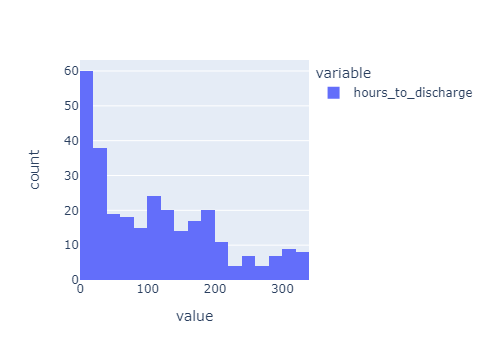

In [23]:
px.histogram(df.hours_to_discharge)